In [ ]:
# Mount Google Drive if using Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
#from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define input directory (only Medical Expert-I)
expert1_dir = "/content/drive/MyDrive/MedicalExpert-I"

# Output directory for processed images
output_directory = "/content/drive/MyDrive/processed_knee_xrays_expert1"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Function to perform basic augmentation
def augment_image(image):
    augmented_images = [
        cv2.flip(image, 1),  # Horizontal flip
        cv2.flip(image, 0),  # Vertical flip
        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
        cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
        cv2.rotate(image, cv2.ROTATE_180)
    ]
    return augmented_images

# Function to perform extra augmentation for Mild and Doubtful classes
def extra_augment_image(image):
    extra_augmented_images = [
        cv2.GaussianBlur(image, (5, 5), 0),  # Gaussian Blur
        cv2.addWeighted(image, 1.5, np.zeros_like(image), 0, -30),  # Contrast Adjustment
        cv2.GaussianBlur(image, (3, 3), 0),
        cv2.addWeighted(image, 1.3, np.zeros_like(image), 0, -20)
    ]
    return extra_augmented_images

# Store image data in a list
image_data = []

# Process images and apply augmentation
def process_images(source_dir, prefix):
    for category in os.listdir(source_dir):  # Example: "Normal", "Mild", "Moderate", "Severe", "Doubtful"
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    input_path = os.path.join(category_path, filename)

                    # Read image
                    img = cv2.imread(input_path)
                    if img is None:
                        continue  # Skip corrupted images

                    # Save original image
                    new_filename = f"{prefix}_{filename}"
                    output_path = os.path.join(output_directory, new_filename)
                    cv2.imwrite(output_path, img)
                    image_data.append([output_path, category])  # Store metadata

                    # Apply basic augmentation
                    augmented_images = augment_image(img)
                    for idx, aug_img in enumerate(augmented_images):
                        aug_filename = f"{prefix}_{os.path.splitext(filename)[0]}_aug{idx}{os.path.splitext(filename)[1]}"
                        aug_output_path = os.path.join(output_directory, aug_filename)
                        cv2.imwrite(aug_output_path, aug_img)
                        image_data.append([aug_output_path, category])  # Store metadata

                    # Apply extra augmentation for Mild and Doubtful classes
                    if category in ["Mild", "Doubtful"]:
                        extra_augmented_images = extra_augment_image(img)
                        for idx, extra_aug_img in enumerate(extra_augmented_images):
                            extra_aug_filename = f"{prefix}_{os.path.splitext(filename)[0]}_extra_aug{idx}{os.path.splitext(filename)[1]}"
                            extra_aug_output_path = os.path.join(output_directory, extra_aug_filename)
                            cv2.imwrite(extra_aug_output_path, extra_aug_img)
                            image_data.append([extra_aug_output_path, category])  # Store metadata

# Process only images from Medical Expert-I
process_images(expert1_dir, "Expert1")

# Create DataFrame from collected image data
df = pd.DataFrame(image_data, columns=["image_path", "label"])

# Print total images before augmentation
original_counts = df["label"].value_counts()
print("\nOriginal Class Counts (Before Augmentation):")
print(original_counts)

# Split data into train (70%), validation (15%), test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Print dataset sizes after augmentation
print(f"\nTotal Images After Augmentation: {len(df)}")
print(f"Training Set: {len(train_df)}")
print(f"Validation Set: {len(val_df)}")
print(f"Test Set: {len(test_df)}")

# Print class distributions
print("\nClass Distribution in Training Set:")
print(train_df["label"].value_counts())

print("\nClass Distribution in Validation Set:")
print(val_df["label"].value_counts())

print("\nClass Distribution in Test Set:")
print(test_df["label"].value_counts())

print("\nData preprocessing and augmentation complete!")



Original Class Counts (Before Augmentation):
label
0Normal      3084
1Doubtful    2862
2Mild        1392
3Moderate    1326
4Severe      1236
Name: count, dtype: int64

Total Images After Augmentation: 9900
Training Set: 6930
Validation Set: 1485
Test Set: 1485

Class Distribution in Training Set:
label
0Normal      2159
1Doubtful    2003
2Mild         975
3Moderate     928
4Severe       865
Name: count, dtype: int64

Class Distribution in Validation Set:
label
0Normal      463
1Doubtful    429
2Mild        208
3Moderate    199
4Severe      186
Name: count, dtype: int64

Class Distribution in Test Set:
label
0Normal      462
1Doubtful    430
2Mild        209
3Moderate    199
4Severe      185
Name: count, dtype: int64

Data preprocessing and augmentation complete!


In [ ]:

# Save the datasets (optional)
train_df.to_csv("train_data_expert1.csv", index=False)
val_df.to_csv("val_data_expert1.csv", index=False)
test_df.to_csv("test_data_expert1.csv", index=False)

Found 6930 validated image filenames belonging to 5 classes.
Found 1485 validated image filenames belonging to 5 classes.
Found 1485 validated image filenames belonging to 5 classes.
Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 153s 525ms/step - accuracy: 0.2993 - loss: 1.7357 - val_accuracy: 0.4741 - val_loss: 1.2837
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 64s 293ms/step - accuracy: 0.4104 - loss: 1.3577 - val_accuracy: 0.5582 - val_loss: 1.1395
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 62s 287ms/step - accuracy: 0.4986 - loss: 1.2041 - val_accuracy: 0.5939 - val_loss: 1.0384
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 60s 274ms/step - accuracy: 0.5339 - loss: 1.1279 - val_accuracy: 0.5973 - val_loss: 0.9876
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 58s 266ms/step - accuracy: 0.5646 - loss: 1.0419 - val_accuracy: 0.6249 - val_loss: 0.9362
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 263ms/step - accuracy: 0.5929 - loss: 0.9921 - val_accuracy: 0.6370 - val_loss: 0.8904
Epoch 7/100
217/217 ━━━━

Training complete! Model saved.

Epoch-wise Training & Validation Accuracy:
Epoch 1: Train Accuracy = 0.3352, Validation Accuracy = 0.4741
Epoch 2: Train Accuracy = 0.4387, Validation Accuracy = 0.5582
Epoch 3: Train Accuracy = 0.5022, Validation Accuracy = 0.5939
Epoch 4: Train Accuracy = 0.5447, Validation Accuracy = 0.5973
Epoch 5: Train Accuracy = 0.5622, Validation Accuracy = 0.6249
Epoch 6: Train Accuracy = 0.5938, Validation Accuracy = 0.6370
Epoch 7: Train Accuracy = 0.6147, Validation Accuracy = 0.6572
Epoch 8: Train Accuracy = 0.6277, Validation Accuracy = 0.6566
Epoch 9: Train Accuracy = 0.6455, Validation Accuracy = 0.6815
Epoch 10: Train Accuracy = 0.6528, Validation Accuracy = 0.6815
Epoch 11: Train Accuracy = 0.6635, Validation Accuracy = 0.6781
Epoch 12: Train Accuracy = 0.6791, Validation Accuracy = 0.6855
Epoch 13: Train Accuracy = 0.6828, Validation Accuracy = 0.6815
Epoch 14: Train Accuracy = 0.6900, Validation Accuracy = 0.6963
Epoch 15: Train Accuracy = 0.7097, Va

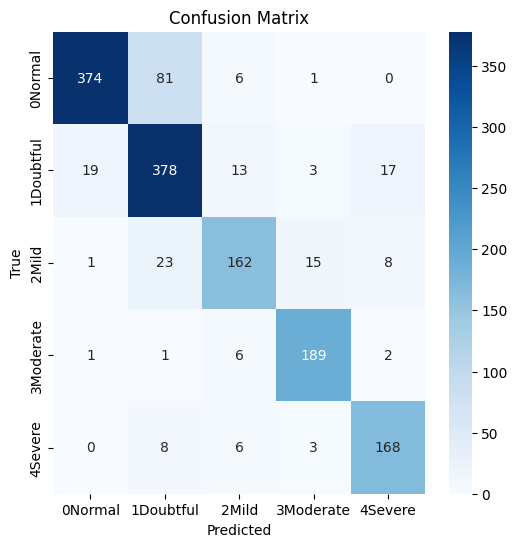


Classification Report:
               precision    recall  f1-score   support

     0Normal       0.95      0.81      0.87       462
   1Doubtful       0.77      0.88      0.82       430
       2Mild       0.84      0.78      0.81       209
   3Moderate       0.90      0.95      0.92       199
     4Severe       0.86      0.91      0.88       185

    accuracy                           0.86      1485
   macro avg       0.86      0.86      0.86      1485
weighted avg       0.86      0.86      0.86      1485



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load CSV with image paths and labels
df_train = pd.read_csv("train_data_expert1.csv")
df_val = pd.read_csv("val_data_expert1.csv")
df_test = pd.read_csv("test_data_expert1.csv")

# Define image dimensions and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerators
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_dataframe(
    df_train,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = datagen.flow_from_dataframe(
    df_val,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = datagen.flow_from_dataframe(
    df_test,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Load Pretrained DenseNet121 Model
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers (for transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Custom Fully Connected Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation="softmax")(x)  # 5 classes in your dataset

# Create Final Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Model
EPOCHS = 100
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1  # Print training accuracy for each epoch
)

# Save Model
model.save("densenet121_knee_xray_classifier.h5")
print("Training complete! Model saved.")

# ==============================
# Print Training & Validation Accuracy for Each Epoch
# ==============================
print("\nEpoch-wise Training & Validation Accuracy:")
for epoch in range(EPOCHS):
    train_acc = history.history["accuracy"][epoch]
    val_acc = history.history["val_accuracy"][epoch]
    print(f"Epoch {epoch+1}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {val_acc:.4f}")

# ==============================
#  Confusion Matrix on Test Data
# ==============================
# Predict test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class index with highest probability
y_true = test_gen.classes  # True class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ==============================
#  Classification Report
# ==============================
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("\nClassification Report:\n", report)
